In [472]:
import itertools
from math import pi
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np


import networkx as nx
from neal import SimulatedAnnealingSampler

In [473]:
def generate_random_graph(num_nodes, edge_probability, seed=None):
    """
    Generates random graph with Erdos-Renyi model (G(n, p)).
    """
    if not (0.0 <= edge_probability <= 1.0):
        raise ValueError("Probability has to be between 0.0 and 1.0.")
        
    G = nx.fast_gnp_random_graph(
        n=num_nodes, 
        p=edge_probability, 
        seed=seed
    )
    
    return G

In [474]:
n_wires = 6
prob = 0.5

random_graph = generate_random_graph(n_wires, prob)

edges = random_graph.edges()

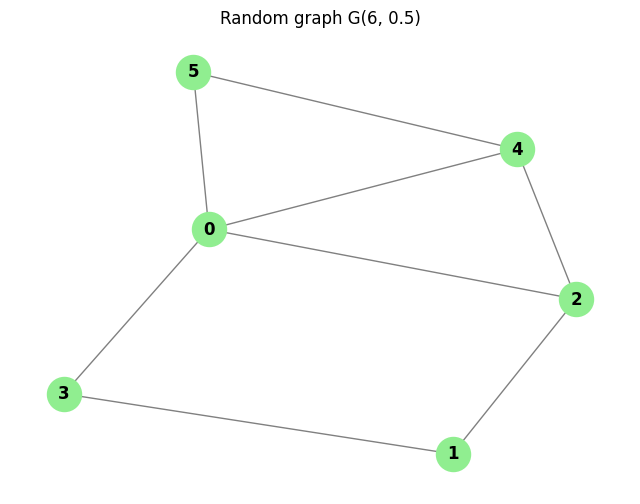

In [475]:
plt.figure(figsize=(8, 6))
plt.title(f"Random graph G({n_wires}, {prob})")
pos = nx.spring_layout(random_graph, seed=42)
nx.draw(random_graph, pos, 
        with_labels=True, 
        node_color='lightgreen', 
        node_size=600, 
        edge_color='gray', 
        font_weight='bold')

In [476]:
def bitstring_to_int(bit_string_sample):
    return int(2 ** np.arange(len(bit_string_sample)) @ bit_string_sample[::-1])

def cut_value(bitstring, edges):
    if isinstance(bitstring, str):
        b = [int(x) for x in bitstring]
    else:
        b = list(bitstring)
    val = 0
    for (i, j) in edges:
        if b[i] != b[j]:
            val += 1
    return val

def maxcut_bruteforce(n, edges):
    best = -1
    best_strings = []
    for bits in itertools.product([0,1], repeat=n):
        v = cut_value(bits, edges)
        if v > best:
            best = v
            best_strings = [bits]
        elif v == best:
            best_strings.append(bits)
    return best, best_strings

In [477]:
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)

def U_C(gamma):
    for edge in edges:
        qml.IsingZZ(gamma, wires=edge)

In [478]:
best_classic_val, best_classic_strings = maxcut_bruteforce(n_wires, edges)
print("Classical optimum (bruteforce):", best_classic_val, "\nSolutions:", [tuple(b) for b in best_classic_strings])

Classical optimum (bruteforce): 7 
Solutions: [(0, 0, 1, 1, 0, 1), (1, 1, 0, 0, 1, 0)]


In [479]:
dev = qml.device("lightning.qubit", wires=n_wires, shots=20)

@qml.qnode(dev)
def circuit(gammas, betas, return_samples=False):
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    for gamma, beta in zip(gammas, betas):
        U_C(gamma)
        U_B(beta)

    if return_samples:
        return qml.sample()
    C = qml.sum(*(qml.Z(w1) @ qml.Z(w2) for w1, w2 in edges))
    return qml.expval(C)


def objective(params):
    return -0.5 * (len(edges) - circuit(*params))

def qaoa_maxcut(n_layers=1):
    print(f"\np={n_layers:d}")

    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

    opt = qml.AdagradOptimizer(stepsize=0.5)

    params = init_params.copy()
    steps = 30
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print(f"Objective after step {i+1:3d}: {-objective(params): .2f}")

    bitstrings = circuit(*params, return_samples=True, shots=500)
    sampled_ints = [bitstring_to_int(string) for string in bitstrings]

    counts = np.bincount(np.array(sampled_ints))
    most_freq_bit_string = np.argmax(counts)
    print(f"Optimized parameter vectors:\ngamma: {params[0]}\nbeta:  {params[1]}")
    print(f"Most frequently sampled bit string is: {most_freq_bit_string:06b}")

    return -objective(params), sampled_ints


p=1


c:\Users\jakub\anaconda3\envs\quant\Lib\site-packages\pennylane\ops\op_math\composite.py:209: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in staticmethod() if you want to preserve the old behavior
  return self._math_op(math.vstack(eigvals), axis=0)


Objective after step   5:  4.95
Objective after step  10:  4.90
Objective after step  15:  4.90
Objective after step  20:  5.30
Objective after step  25:  5.15
Objective after step  30:  5.00
Optimized parameter vectors:
gamma: [-0.66911447]
beta:  [-1.28501542]
Most frequently sampled bit string is: 110010

p=2
Objective after step   5:  4.40
Objective after step  10:  4.80
Objective after step  15:  4.80
Objective after step  20:  4.50
Objective after step  25:  5.30
Objective after step  30:  4.65
Optimized parameter vectors:
gamma: [-1.23262334 -1.05215564]
beta:  [ 0.20039942 -0.34775534]
Most frequently sampled bit string is: 000101


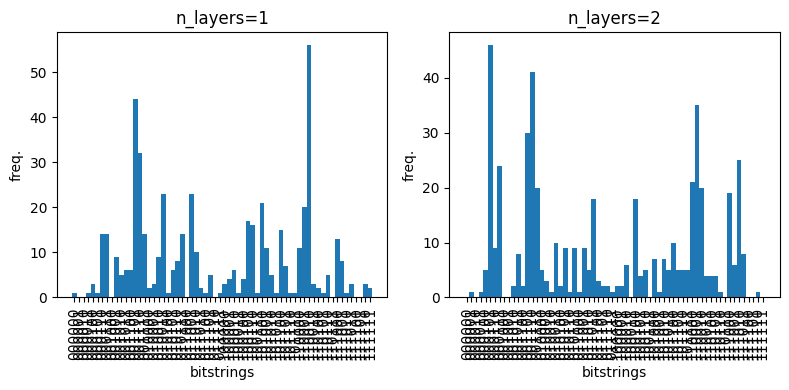

In [480]:
int_samples1 = qaoa_maxcut(n_layers=1)[1]
int_samples2 = qaoa_maxcut(n_layers=2)[1]

xticks = range(0, 2**n_wires)
xtick_labels = list(map(lambda x: format(x, "06b"), xticks))
bins = np.arange(0, 2**n_wires+1) - 0.5

fig, _ = plt.subplots(1, 2, figsize=(8, 4))
for i, samples in enumerate([int_samples1, int_samples2], start=1):
    plt.subplot(1, 2, i)
    plt.title(f"n_layers={i}")
    plt.xlabel("bitstrings")
    plt.ylabel("freq.")
    plt.xticks(xticks, xtick_labels, rotation="vertical")
    plt.hist(samples, bins=bins)
plt.tight_layout()

In [481]:
def max_cut_to_qubo():
    Q = {}

    for u, v in edges:
        Q[(u, v)] = Q.get((u, v), 0) + 2
        
        Q[(u, u)] = Q.get((u, u), 0) - 1
        Q[(v, v)] = Q.get((v, v), 0) - 1
        
    return Q

In [482]:
Q_qubo = max_cut_to_qubo()

sampler = SimulatedAnnealingSampler()

response = sampler.sample_qubo(Q_qubo, num_reads=200)

best_sample = response.first.sample
best_energy = response.first.energy

partition_A = [k for k, v in best_sample.items() if v == 0]
partition_B = [k for k, v in best_sample.items() if v == 1]


def calculate_cut_value(graph, partition_A, partition_B):
    cut_value = 0
    set_A = set(partition_A)
    for u, v in edges:
        if (u in set_A) != (v in set_A):
            cut_value += 1
    return cut_value

max_cut_value = calculate_cut_value(random_graph, partition_A, partition_B)

print("==============================================")
print("Max-Cut (Simulated Annealing)")
print("==============================================")
print(f"Partition A (Group 0): {partition_A}")
print(f"Partition B (Group 1): {partition_B}")
print(f"Max cut value: {max_cut_value}")
print(f"Minimal QUBO energy: {best_energy}")


Max-Cut (Simulated Annealing)
Partition A (Group 0): [2, 3, 5]
Partition B (Group 1): [0, 1, 4]
Max cut value: 7
Minimal QUBO energy: -7.0


(np.float64(-0.5513332304385612),
 np.float64(0.4996522146845431),
 np.float64(-1.1726437286042222),
 np.float64(1.2064503090528897))

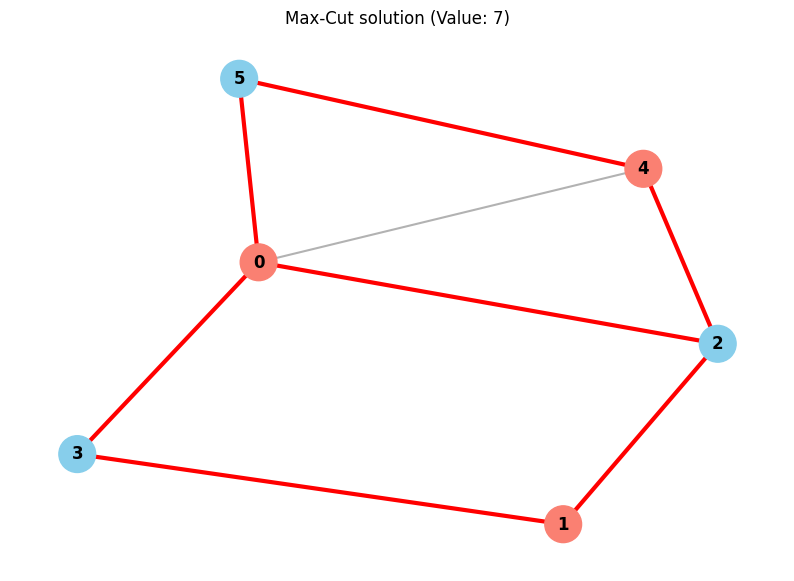

In [483]:
pos = nx.spring_layout(random_graph, seed=42) 

node_colors = []
for node in random_graph.nodes():
    if node in partition_A:
        node_colors.append('skyblue')
    else:
        node_colors.append('salmon')

edge_colors = []
cut_edges = []
for u, v in edges:
    u_in_A = u in partition_A
    v_in_A = v in partition_A
    
    if u_in_A != v_in_A:
        edge_colors.append('red')
        cut_edges.append((u, v))
    else:
        edge_colors.append('gray')

plt.figure(figsize=(10, 7))
plt.title(f"Max-Cut solution (Value: {max_cut_value})")

nx.draw_networkx_nodes(random_graph, pos, node_color=node_colors, node_size=700)

nx.draw_networkx_edges(random_graph, pos, 
                       edgelist=cut_edges, 
                       edge_color='red', 
                       width=3.0, 
                       label='Cut Edges')

intra_edges = [e for e in edges if e not in cut_edges]
nx.draw_networkx_edges(random_graph, pos, 
                       edgelist=intra_edges, 
                       edge_color='gray', 
                       width=1.5, 
                       alpha=0.6)

nx.draw_networkx_labels(random_graph, pos, font_color='black', font_weight='bold')

plt.axis('off')